In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.autograd import Function, Variable
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import numpy as np

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [379]:
def lorenz(state, t, sigma, beta, rho):
    x, y, z = state
     
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
     
    return [dx, dy, dz]

t_0 = 0.
t_f = 6.
dt = 0.01

sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

sigma0 = sigma
beta0 = beta
rho0 = rho

y0 = [1,1,1]
N = int((t_f - t_0)/.01)

NN_input = np.zeros([6,1,N])
NN_output = np.zeros([3,1,N])

t = np.arange(t_0, t_f, dt)

result = np.zeros([3,1,N-2])
d_result = np.zeros([3,1,N-2])
for i in range(N-2):
    rho = rho0 + 20.*np.random.rand()
    beta = beta0 + 5.*np.random.rand()
    sigma = sigma0 + 10.*np.random.rand()
    
    rho = rho0 + 0.25*np.cos(i/2)
    beta = beta0 + 0.15*np.cos(i/4)+ 0.25*np.sin(i/2)
    sigma = sigma0 + 0.25*np.cos(i/2) + 0.05*np.cos(i/8)
    
    
    #rho = rho0 + 5.5 *np.cos(i/2)
    #beta = beta0 + 1.5*np.cos(i/4)+ 2.5*np.sin(i/2)
    #sigma = sigma0 + 2.5*np.cos(i/2) + 1.5*np.cos(i/8)
    
    NN_output[:,0,i] = np.array([sigma,rho, beta])
    T = (t[i:i+2])
    p = (sigma, beta, rho)
    d_result[:,0,i] = lorenz(y0, T, sigma, beta, rho)
    
    result[:,0,i] = odeint(lorenz, y0, T, p)[1]
    y0 = result[:,0,i]
    
NN_output = NN_output[:,:,:-2]




In [380]:
from sklearn.preprocessing import MinMaxScaler, Normalizer,StandardScaler

SIGMA = NN_output[0,0,:]
BETA = NN_output[1,0,:]
RHO = NN_output[2,0,:]

max_SIGMA = np.max(SIGMA);min_SIGMA = np.min(SIGMA);
max_BETA = np.max(BETA);min_BETA = np.min(BETA);
max_RHO = np.max(RHO);min_RHO = np.min(RHO);

#NN_output[0,0,:] = (SIGMA - min_SIGMA)/(max_SIGMA-min_SIGMA)
#NN_output[1,0,:] = (BETA - min_BETA)/(max_BETA-min_BETA)
#NN_output[2,0,:] = (RHO - min_RHO)/(max_RHO-min_RHO)




In [415]:
import pynumdiff
X = result[0,0, :]
Y = result[1,0, :]
Z = result[2,0, :]

dX_real = d_result[0,0, :]
dY_real = d_result[1,0, :]
dZ_real = d_result[2,0, :]

dt = 0.01



dxdt_truth = dX_real 
x_truth = X
noise_parameters = [0, 0.01]  # mean and std
params = [noise_parameters[1]**2, 1e6]

simulate = pynumdiff.utils.simulate
evaluate = pynumdiff.utils.evaluate
x_hat, dxdt_hat = pynumdiff.kalman_smooth.constant_jerk(X, dt, params)
y_hat, dydt_hat = pynumdiff.kalman_smooth.constant_jerk(Y, dt, params)
z_hat, dzdt_hat = pynumdiff.kalman_smooth.constant_jerk(Z, dt, params)



NN_input = np.concatenate((X.reshape(-1,1),Y.reshape(-1,1),Z.reshape(-1,1),dxdt_hat.reshape(-1,1),dydt_hat.reshape(-1,1),dzdt_hat.reshape(-1,1)),axis=1)

NN_input = NN_input.reshape(6,1,-1)


RMS error in velocity:  5.937246455544094


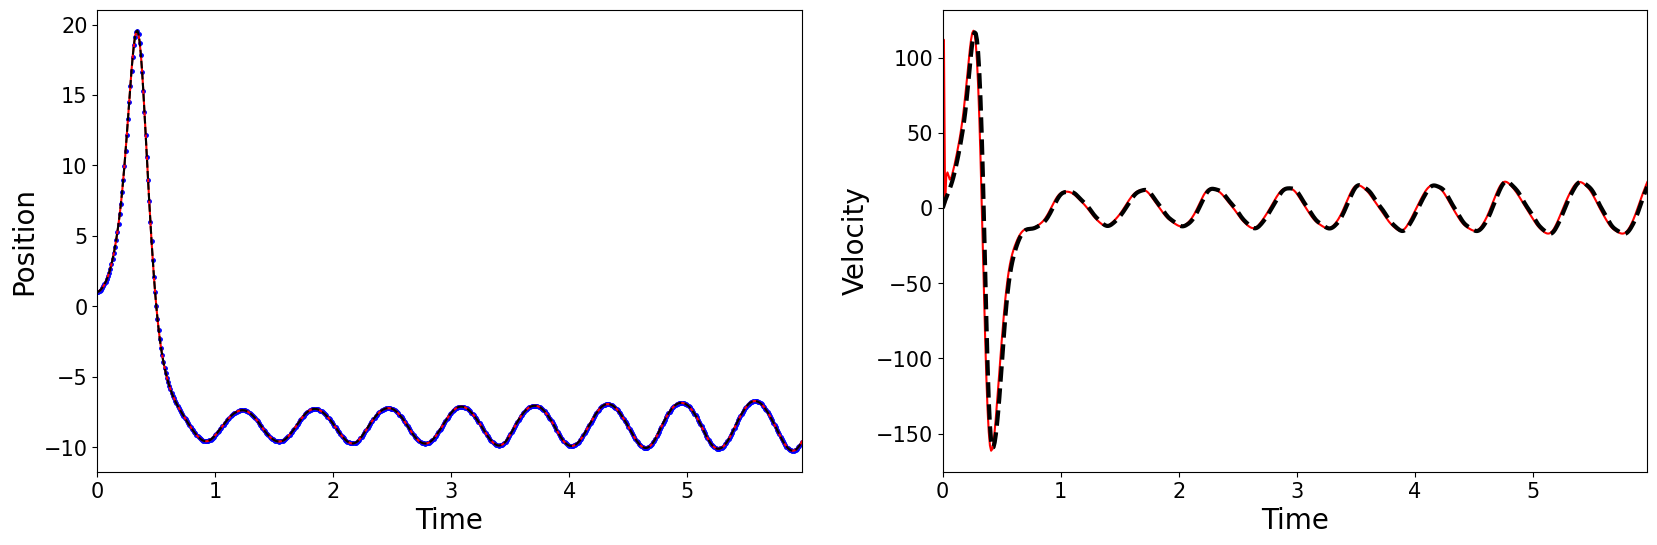

In [416]:
evaluate.plot(X, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)
plt.show()

In [417]:
x = NN_input
Y = NN_output
N_train = int(0.8*np.shape(NN_input)[2])


xx = x
YY = Y
x_train = x[:,:,0:N_train]
Y_train = Y[:,:,0:N_train]
pred_train = np.zeros_like(Y_train)

x_test = xx[:,:,N_train:]
Y_test = YY[:,:,N_train:]


x_test = torch.tensor(x_test)
Y_test = torch.tensor(Y_test)
pred_test = np.zeros_like(Y_test)

x = torch.tensor(x_train)
Y = torch.tensor(Y_train)

In [541]:
# this is one way to define a network
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    #print(lim)
    return (0.5, 1)

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.L1 = torch.nn.Linear(6, 10,bias=True)
        self.L2 = torch.nn.Linear(10, 10,bias=True)
        self.L3 = torch.nn.Linear(10, 10,bias=True)
        self.L4 = torch.nn.Linear(10, 10,bias=True)
        self.L5 = torch.nn.Linear(10, 1,bias=True)   # hidden layer
        self.reset_parameters()

        #self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer
    def reset_parameters(self):
        self.L1.weight.data.uniform_(*hidden_init(self.L1))
        self.L2.weight.data.uniform_(*hidden_init(self.L2))
        self.L3.weight.data.uniform_(*hidden_init(self.L3))
        self.L4.weight.data.uniform_(*hidden_init(self.L4))
        self.L5.weight.data.uniform_(*hidden_init(self.L5))

    def forward(self, x):
        TanH = nn.Tanh()
        SoftSign = nn.Softsign()
        ReLU = nn.ReLU()
        Softplus = nn.Softplus()
        Dropout = nn.Dropout(p=0.1)
        Sigmoid = nn.Sigmoid()
        ep = 0.0001
        #x = Sigmoid(x)*torch.log(Sigmoid(x)*x+ep)
        x = self.L1(x)
        x = Softplus(x)
        #x = torch.log(x+0.001)
        
        #x = SoftSign(x)
        #x = Dropout(x)
        x = self.L2(x)
        #x = Softplus(x)
        x = TanH(x)
        #x = SoftSign(x)
        #x = Dropout(x)
        x = self.L3(x)
        x = TanH(x)
        x = TanH(x)
        #x = Softplus(x)
        x = self.L4(x)
        #x = Softplus(x)
        x = TanH(x)
        x = TanH(x)
        #x = Dropout(x)
        #x = TanH(x)
        x = self.L5(x)

        #x = Softplus(x)
        #x = SoftSign(x)

        #x[0,0] = 4.*x[0,0]+ 9.2
        #x[0,1] = 7.*x[0,1]+ 26.3
        #x[0,2] = 1.5*x[0,2]+ 3.

        return x.double()


net_1 = Net(n_feature=6, n_hidden=10, n_output=1)     # define the network
net_2 = Net(n_feature=6, n_hidden=10, n_output=1)     # define the network
net_3 = Net(n_feature=6, n_hidden=10, n_output=1)     # define the network
print(net_1)  # net architecture
optimizer_1 = torch.optim.Adam(net_1.parameters(), lr=0.3)
optimizer_2 = torch.optim.Adam(net_2.parameters(), lr=0.7)
optimizer_3 = torch.optim.Adam(net_3.parameters(), lr=0.3)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss


Net(
  (L1): Linear(in_features=6, out_features=10, bias=True)
  (L2): Linear(in_features=10, out_features=10, bias=True)
  (L3): Linear(in_features=10, out_features=10, bias=True)
  (L4): Linear(in_features=10, out_features=10, bias=True)
  (L5): Linear(in_features=10, out_features=1, bias=True)
)


In [542]:
num_epochs= 10
Loss_train = np.zeros([3,num_epochs])
Loss_test = np.zeros([3,num_epochs])



def fit(num_epochs, model_1,model_2,model_3, loss_fn, opt_1, opt_2, opt_3):
    j = 0
    for epoch in range(num_epochs):
        for i in range(1,N_train):
            xb = x[:,:,i]
            yb_1 = Y[0,:,i]
            yb_2 = Y[1,:,i]
            yb_3 = Y[2,:,i]

            # Generate predictions
            pred_1 = model_1(xb.T.float())
            pred_2 = model_2(xb.T.float())
            pred_3 = model_3(xb.T.float())

            loss_1 = loss_fn(pred_1, yb_1)*100.
            loss_1.backward()
            opt_1.step()
            opt_1.zero_grad()
            pred_train[0,0,i] = pred_1

            loss_2 = loss_fn(pred_2, yb_2)*100.
            loss_2.backward()
            opt_2.step()
            opt_2.zero_grad()
            pred_train[1,0,i] = pred_2

            loss_3 = loss_fn(pred_3, yb_3)*100.
            loss_3.backward()
            opt_3.step()
            opt_3.zero_grad()
            pred_train[2,0,i] = pred_3
            
            Loss_train[0,epoch] = Loss_train[0,epoch] + loss_1 
            Loss_train[1,epoch] = Loss_train[1,epoch] + loss_2
            Loss_train[2,epoch] = Loss_train[2,epoch] + loss_3
        
        for i in range(1,N-N_train-3):
            
            xb = x_test[:,:,i]
            yb_1 = Y_test[0,:,i]
            yb_2 = Y_test[1,:,i]
            yb_3 = Y_test[2,:,i]

                # Generate predictions
            pred_1 = model_1(xb.T.float())
            pred_2 = model_2(xb.T.float())
            pred_3 = model_3(xb.T.float())
            pred_test[0,0,i] = pred_1
            pred_test[1,0,i] = pred_2
            pred_test[2,0,i] = pred_3
                #print(pred)
            loss_1 = loss_fn(pred_1, yb_1)
            loss_2 = loss_fn(pred_2, yb_2)
            loss_3 = loss_fn(pred_3, yb_3)
            
            Loss_test[0,epoch] = Loss_test[0,epoch] + loss_1 
            Loss_test[1,epoch] = Loss_test[1,epoch] + loss_2
            Loss_test[2,epoch] = Loss_test[2,epoch] + loss_3
            

fit(num_epochs, net_1, net_2, net_3, loss_func, optimizer_1, optimizer_2, optimizer_3)

C:\Users\AlirezaBeigi\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


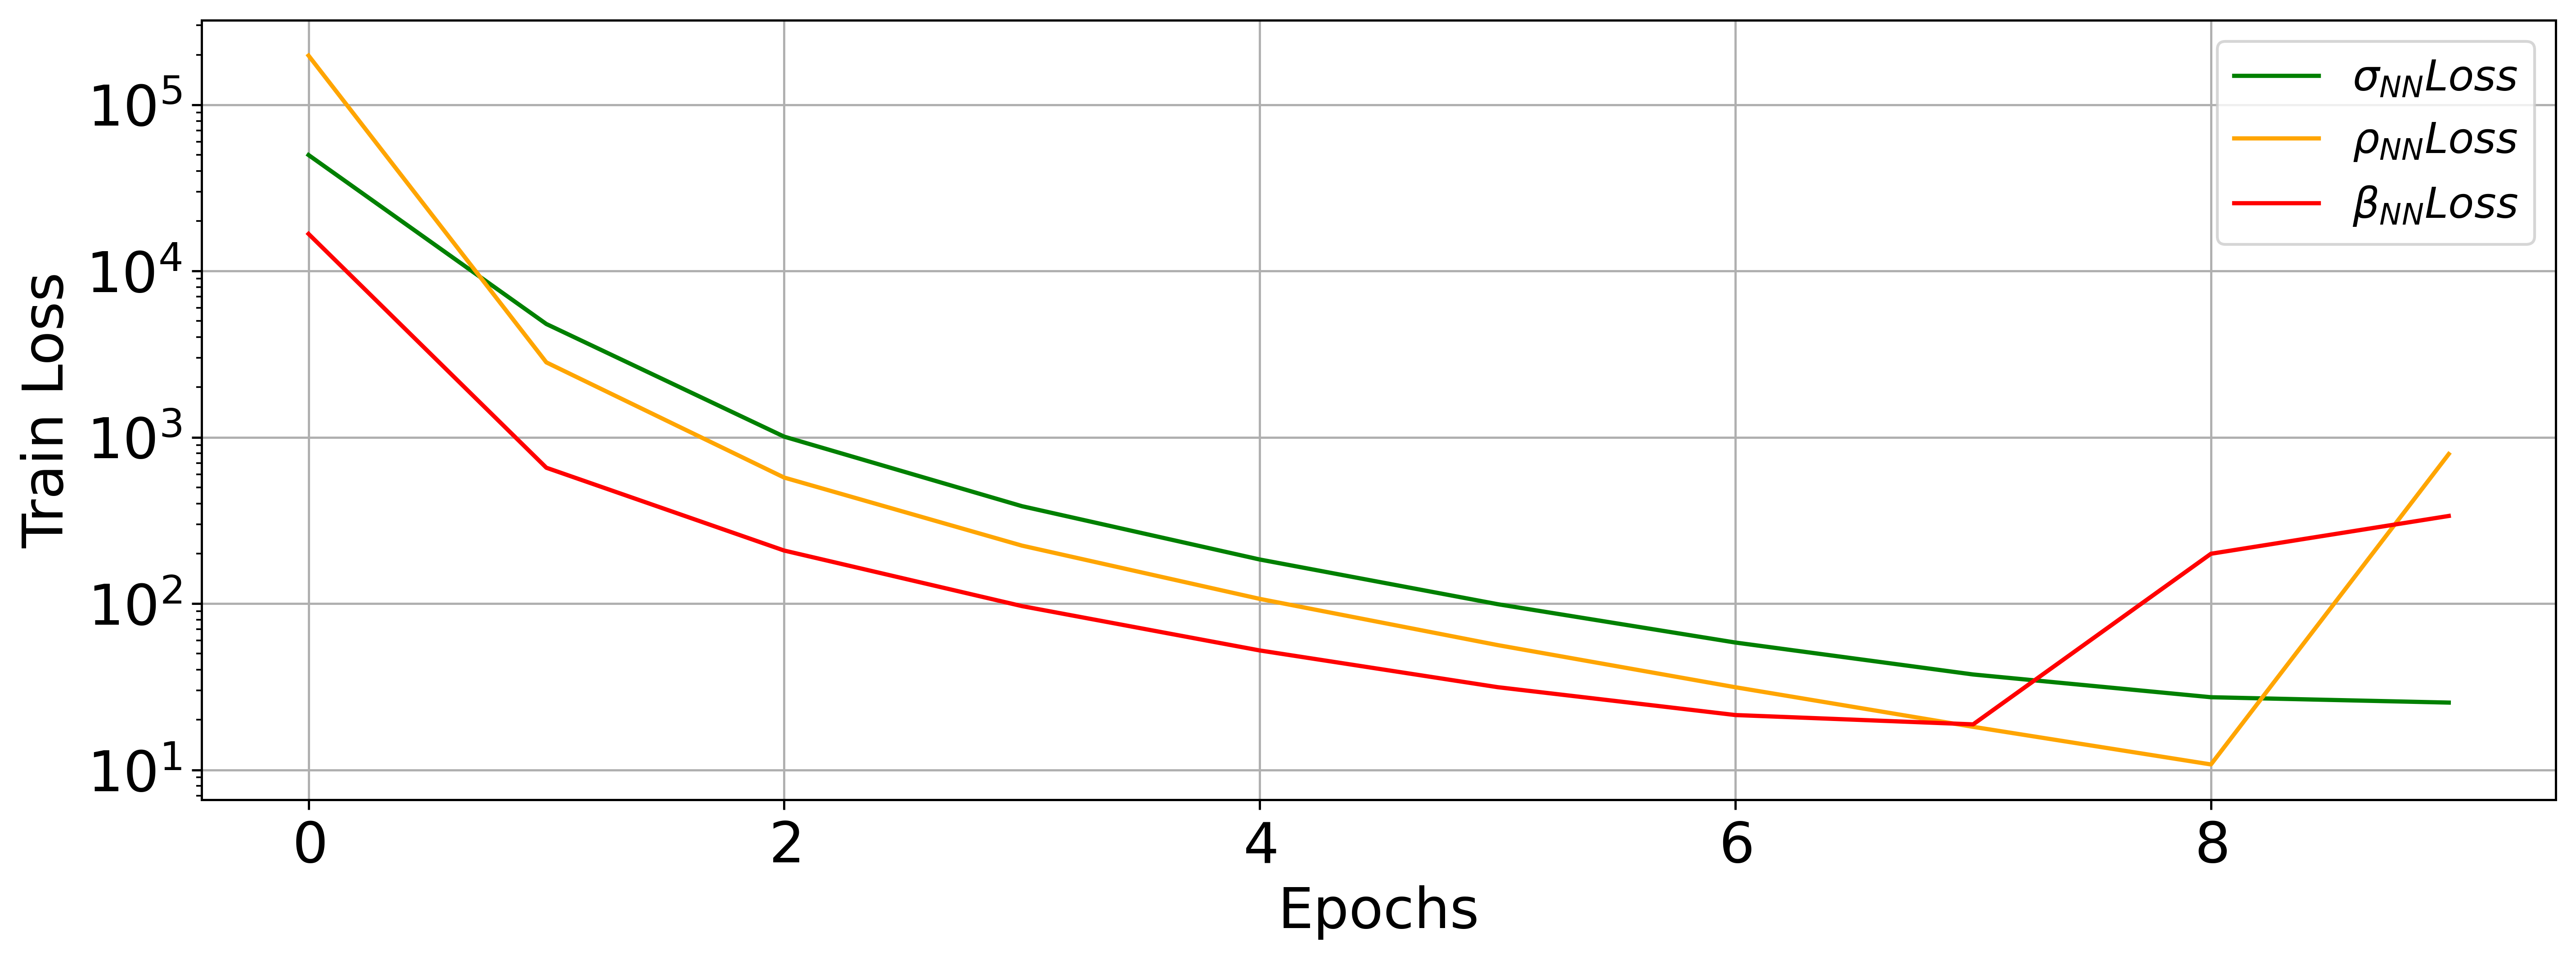

In [601]:
import matplotlib.pyplot as plt



fig=plt.figure(figsize=(15, 5), dpi= 1050, facecolor='w', edgecolor='k')
plt.plot((Loss_train[0,:]),'green')
plt.plot((Loss_train[1,:]),'orange')
plt.plot((Loss_train[2,:]),'r')


plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Train Loss', fontsize=20)
plt.tick_params(labelsize=20)
plt.legend([r'${\sigma_{NN}} Loss$',r'${\rho_{NN}} Loss$',r'${\beta_{NN}} Loss$'],loc='upper right', fontsize=15);
#plt.ylim(bottom= -2*10**5)
#plt.ylim(top=1.5*10**7)
plt.tick_params(axis='both', which='major')
plt.ticklabel_format(style='sci', axis='both', scilimits=(0, 3),useMathText=True)
plt.yscale("log")
plt.grid()
plt.show()

# NN_output[:,0,i] = np.array([sigma,rho, beta])

In [604]:
import matplotlib.pyplot as plt



fig=plt.figure(figsize=(15, 5), dpi= 450, facecolor='w', edgecolor='k')
plt.plot((Loss_test[0,:]),'green')
plt.plot((Loss_test[1,:]),'orange')
plt.plot((Loss_test[2,:]),'r')


plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Test Loss', fontsize=20)
plt.tick_params(labelsize=20)
plt.legend([r'${\sigma_{NN}} Loss$',r'${\rho_{NN}} Loss$',r'${\beta_{NN}} Loss$'],loc='upper right', fontsize=15);
#plt.ylim(bottom= -2*10**5)
#plt.ylim(top=1.5*10**7)
plt.tick_params(axis='both', which='major')
plt.ticklabel_format(style='sci', axis='both', scilimits=(0, 3),useMathText=True)

plt.grid()
plt.show()

# NN_output[:,0,i] = np.array([sigma,rho, beta])

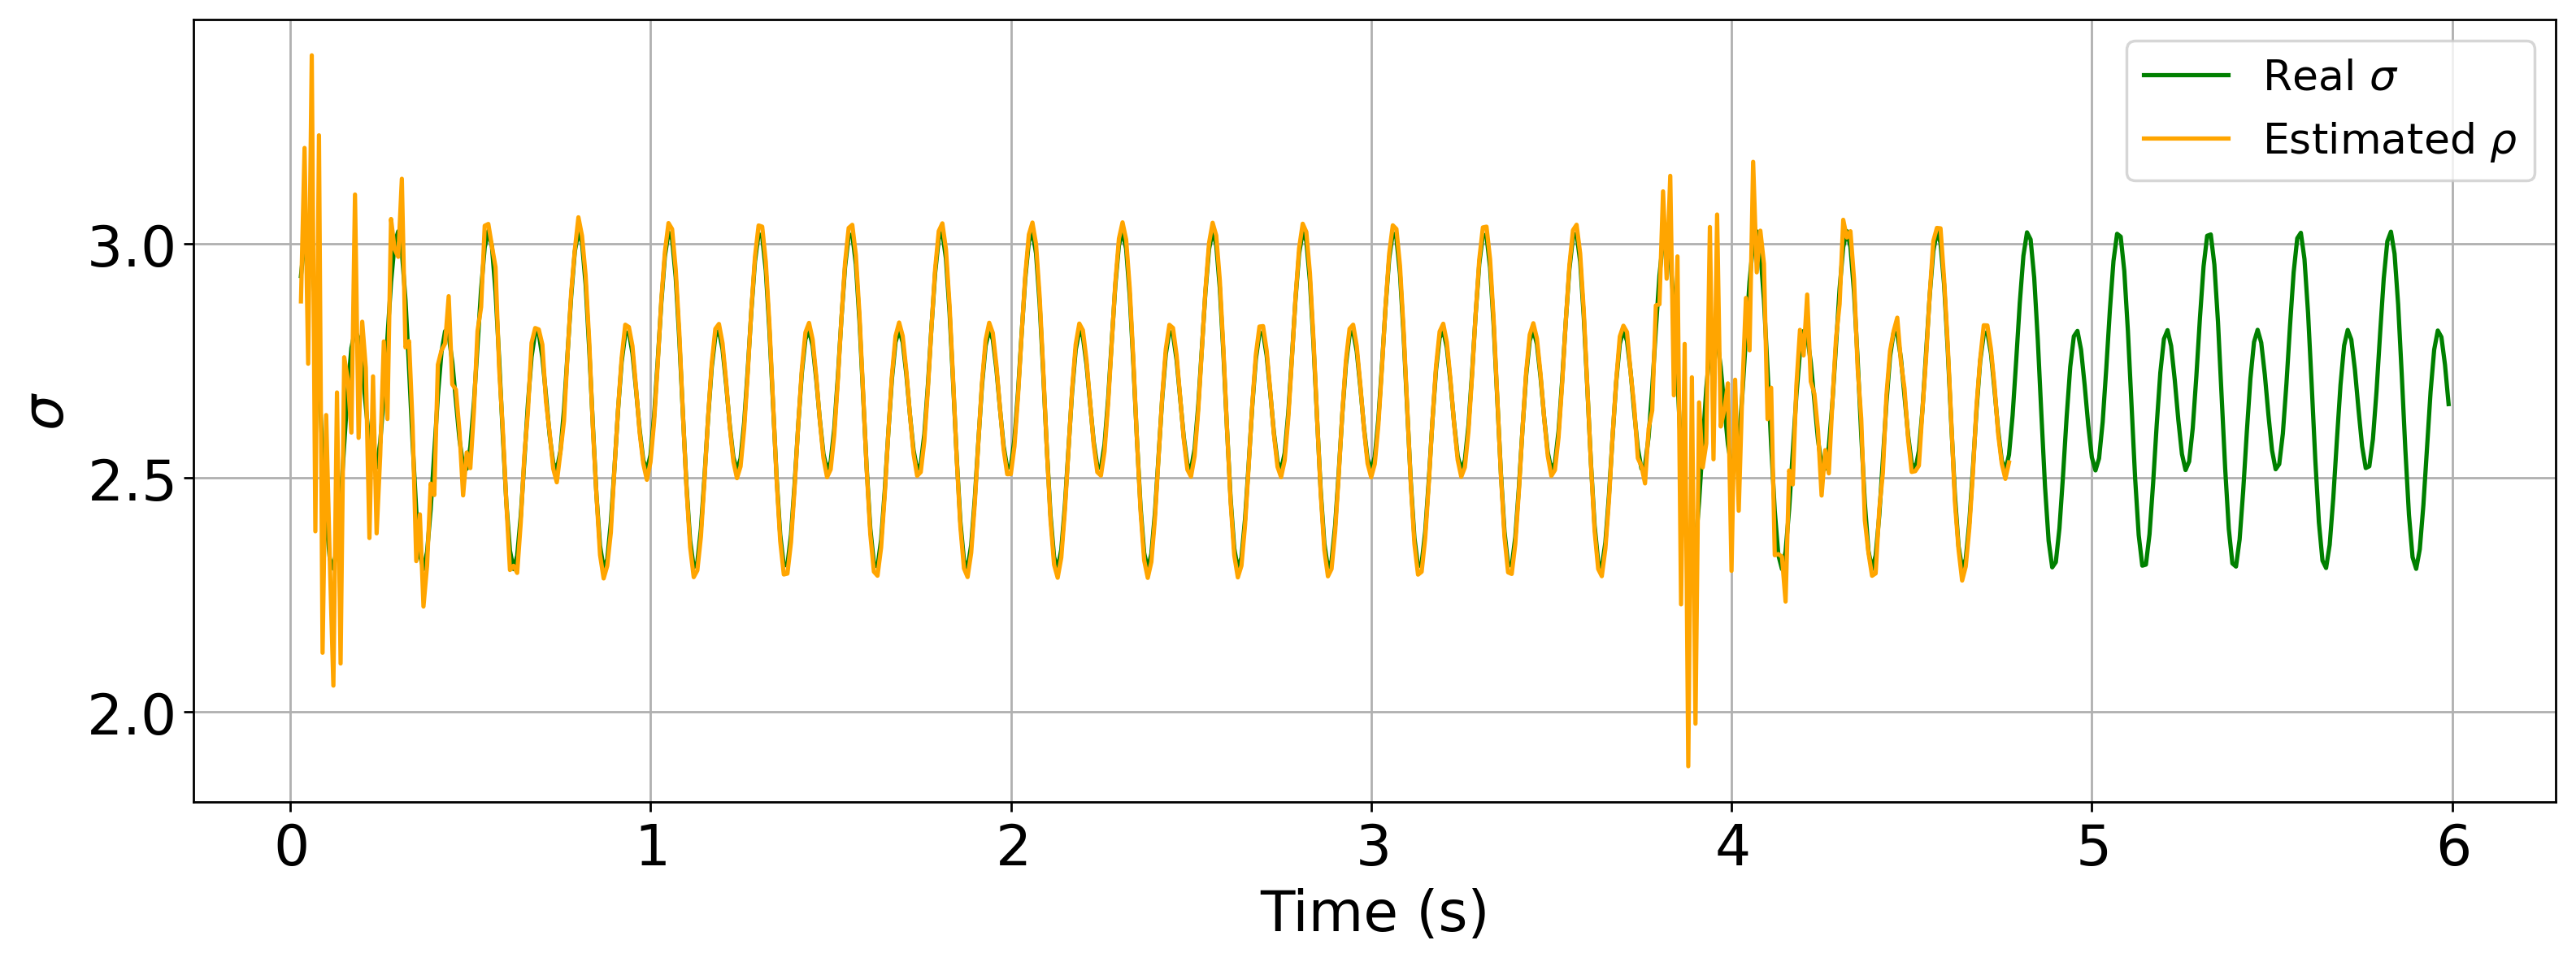

In [615]:
import matplotlib.pyplot as plt



fig=plt.figure(figsize=(15, 5), dpi= 250, facecolor='w', edgecolor='k')
plt.plot(t[3:],NN_output[2,0,1:],'green')
plt.plot(t[3:N_train],pred_train[2,0,1:-2],'orange')
#plt.plot(t[N_train:-2],pred_test[2,0,:],'red')
#plt.plot(t[2:N_train],pred_train[2,0,1:],'orange')

plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'${\sigma}$', fontsize=20)
plt.tick_params(labelsize=20)
plt.legend([r'Real ${\sigma}$',r'Estimated ${\sigma}$'],loc='upper right', fontsize=15);
#plt.ylim(bottom= -2*10**5)
#plt.ylim(top=1.5*10**7)
plt.tick_params(axis='both', which='major')
plt.ticklabel_format(style='sci', axis='both', scilimits=(0, 3),useMathText=True)

plt.grid()
plt.show()

# NN_output[:,0,i] = np.array([sigma,rho, beta])

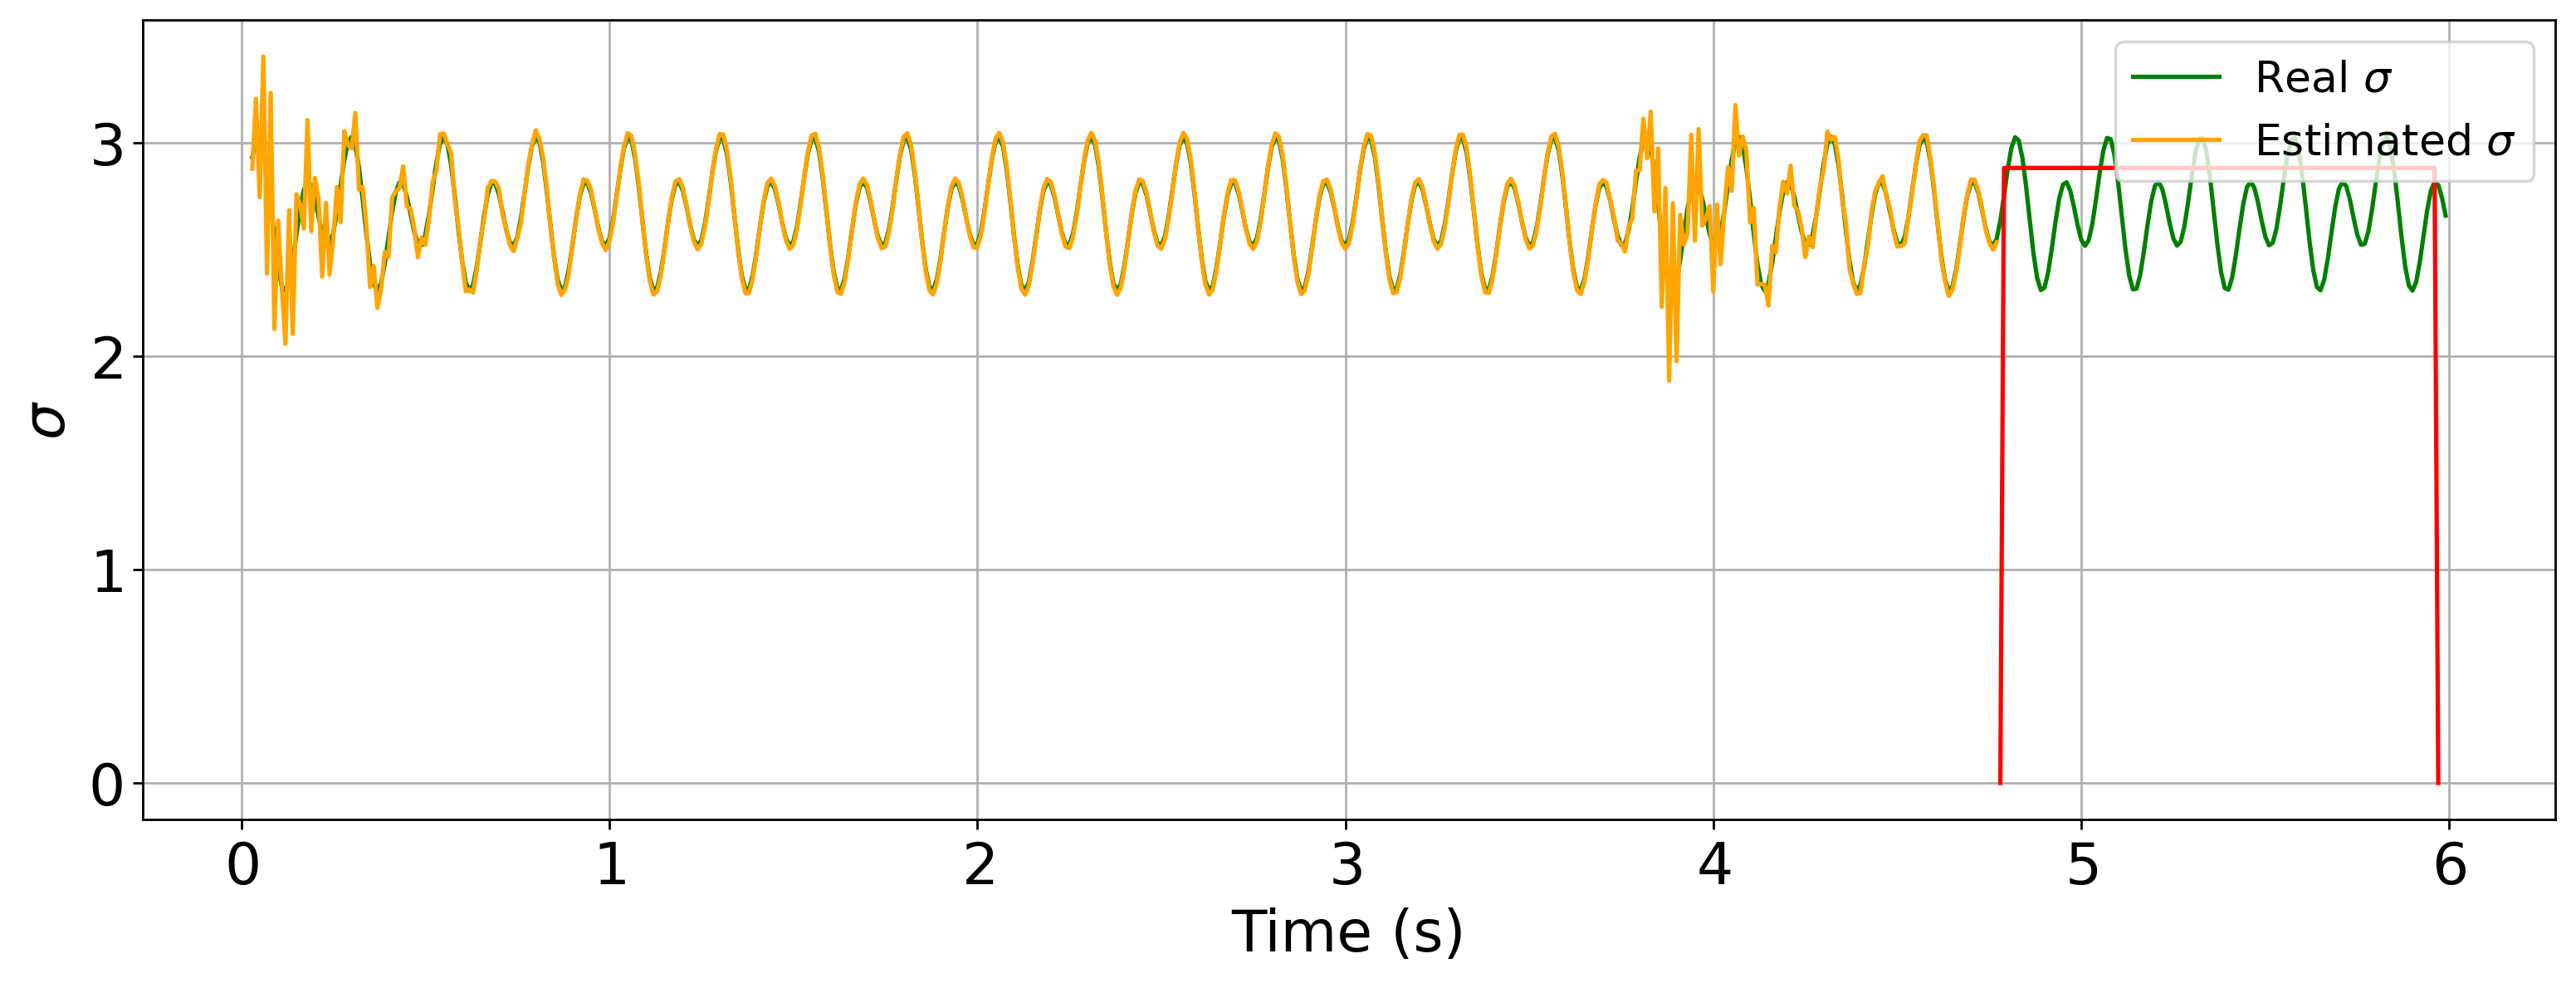

In [625]:
import matplotlib.pyplot as plt



fig=plt.figure(figsize=(15, 5), dpi= 250, facecolor='w', edgecolor='k')
plt.plot(t[3:],NN_output[2,0,1:],'green')
plt.plot(t[3:N_train],pred_train[2,0,1:-2],'orange')
plt.plot(t[N_train:-2],pred_test[2,0,:],'red')
#plt.plot(t[2:N_train],pred_train[2,0,1:],'orange')

plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'${\sigma}$', fontsize=20)
plt.tick_params(labelsize=20)
plt.legend([r'Real ${\sigma}$',r'Estimated ${\sigma}$'],loc='upper right', fontsize=15);
#plt.ylim(bottom= -2*10**5)
#plt.ylim(top=1.5*10**7)
plt.tick_params(axis='both', which='major')
plt.ticklabel_format(style='sci', axis='both', scilimits=(0, 3),useMathText=True)

plt.grid()
plt.show()

# NN_output[:,0,i] = np.array([sigma,rho, beta])

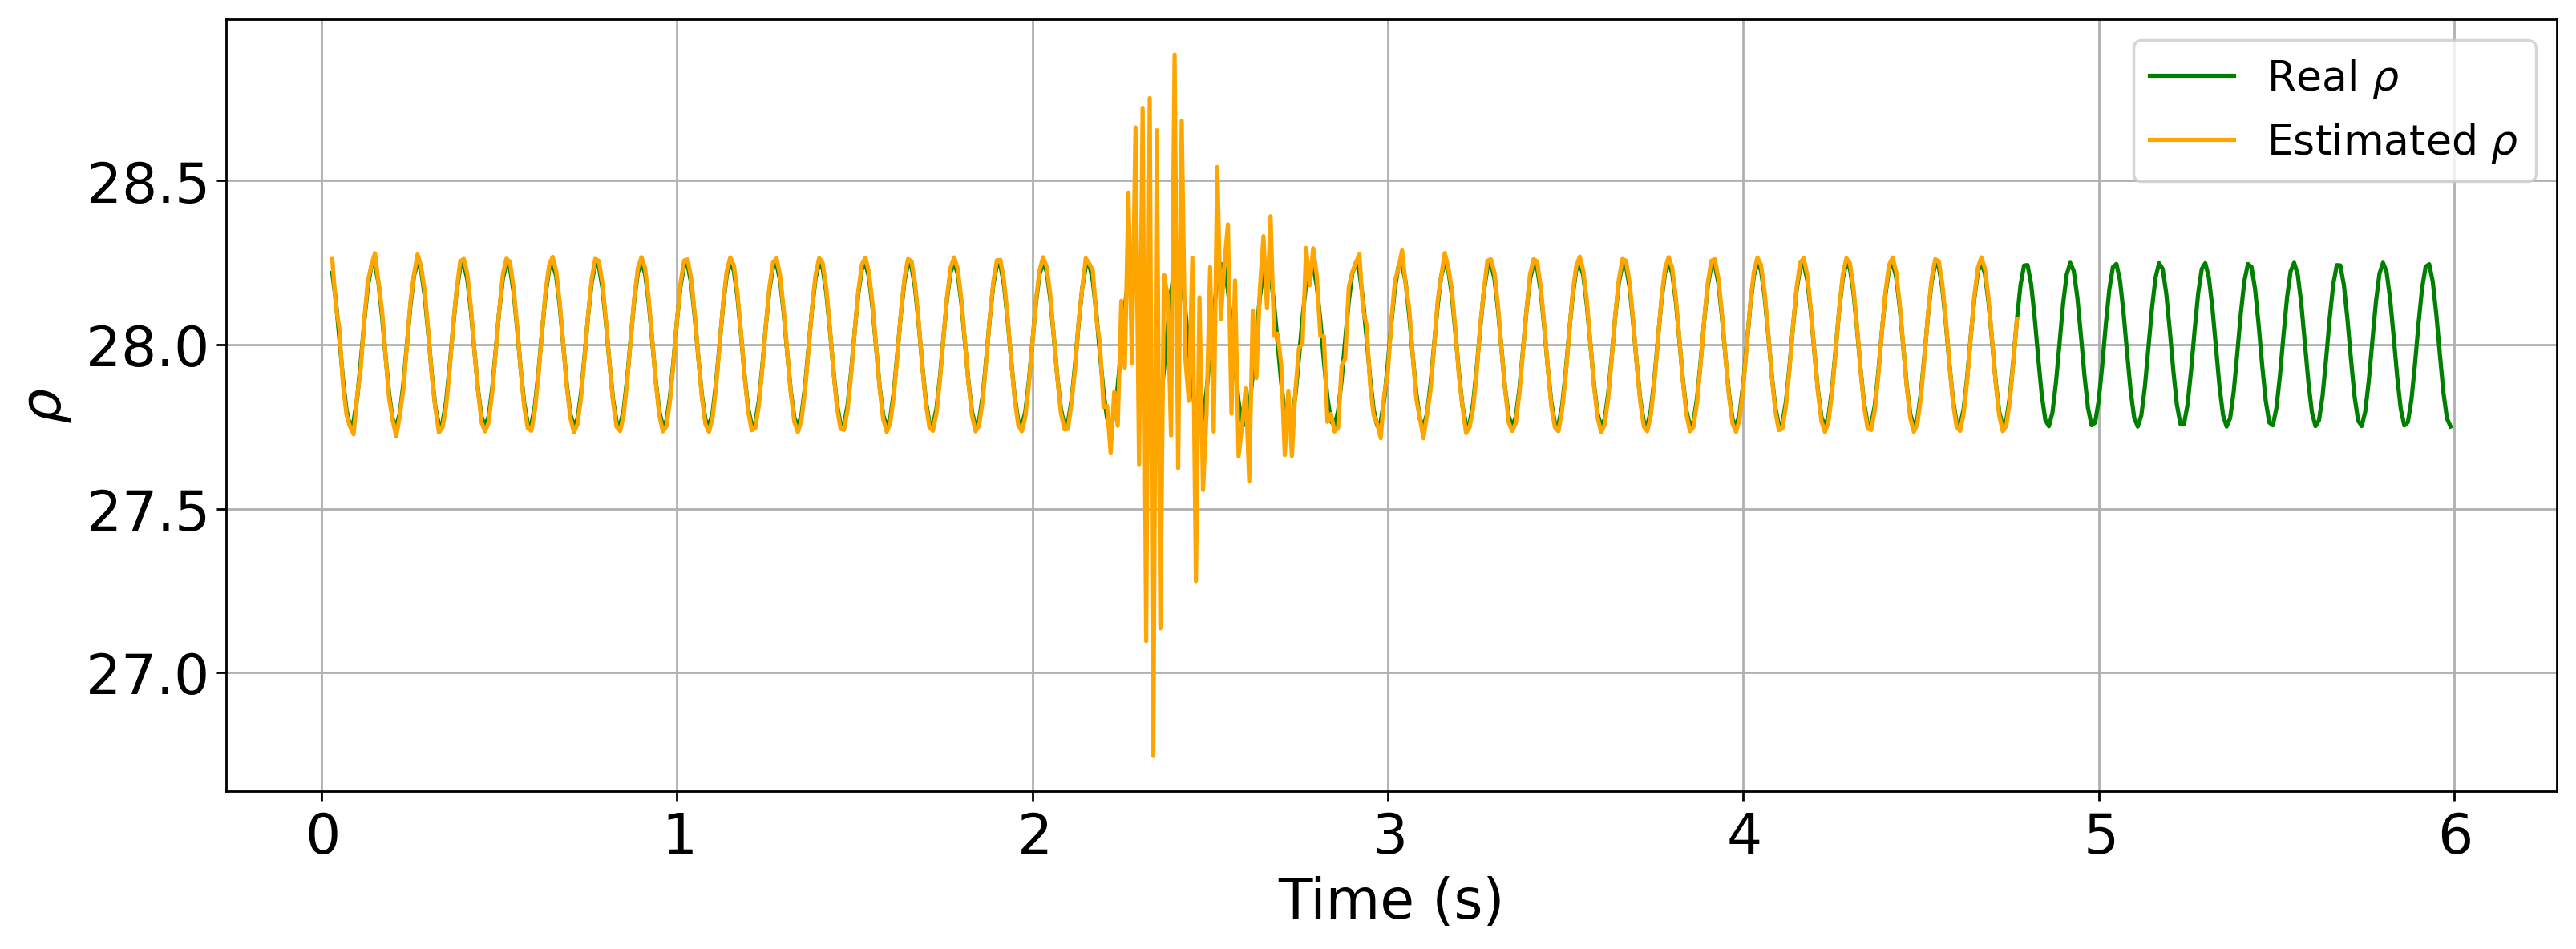

In [620]:
import matplotlib.pyplot as plt



fig=plt.figure(figsize=(15, 5), dpi= 250, facecolor='w', edgecolor='k')
plt.plot(t[3:],NN_output[1,0,1:],'green')
plt.plot(t[3:N_train],pred_train[1,0,1:-2],'orange')
#plt.plot(t[N_train:-2],pred_test[1,0,:],'red')
#plt.plot(t[2:N_train],pred_train[2,0,1:],'orange')

plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'${\rho}$', fontsize=20)
plt.tick_params(labelsize=20)
plt.legend([r'Real ${\rho}$',r'Estimated ${\rho}$'],loc='upper right', fontsize=15);
#plt.ylim(bottom= -2*10**5)
#plt.ylim(top=1.5*10**7)
plt.tick_params(axis='both', which='major')
plt.ticklabel_format(style='sci', axis='both', scilimits=(0, 3),useMathText=True)

plt.grid()
plt.show()

# NN_output[:,0,i] = np.array([sigma,rho, beta])

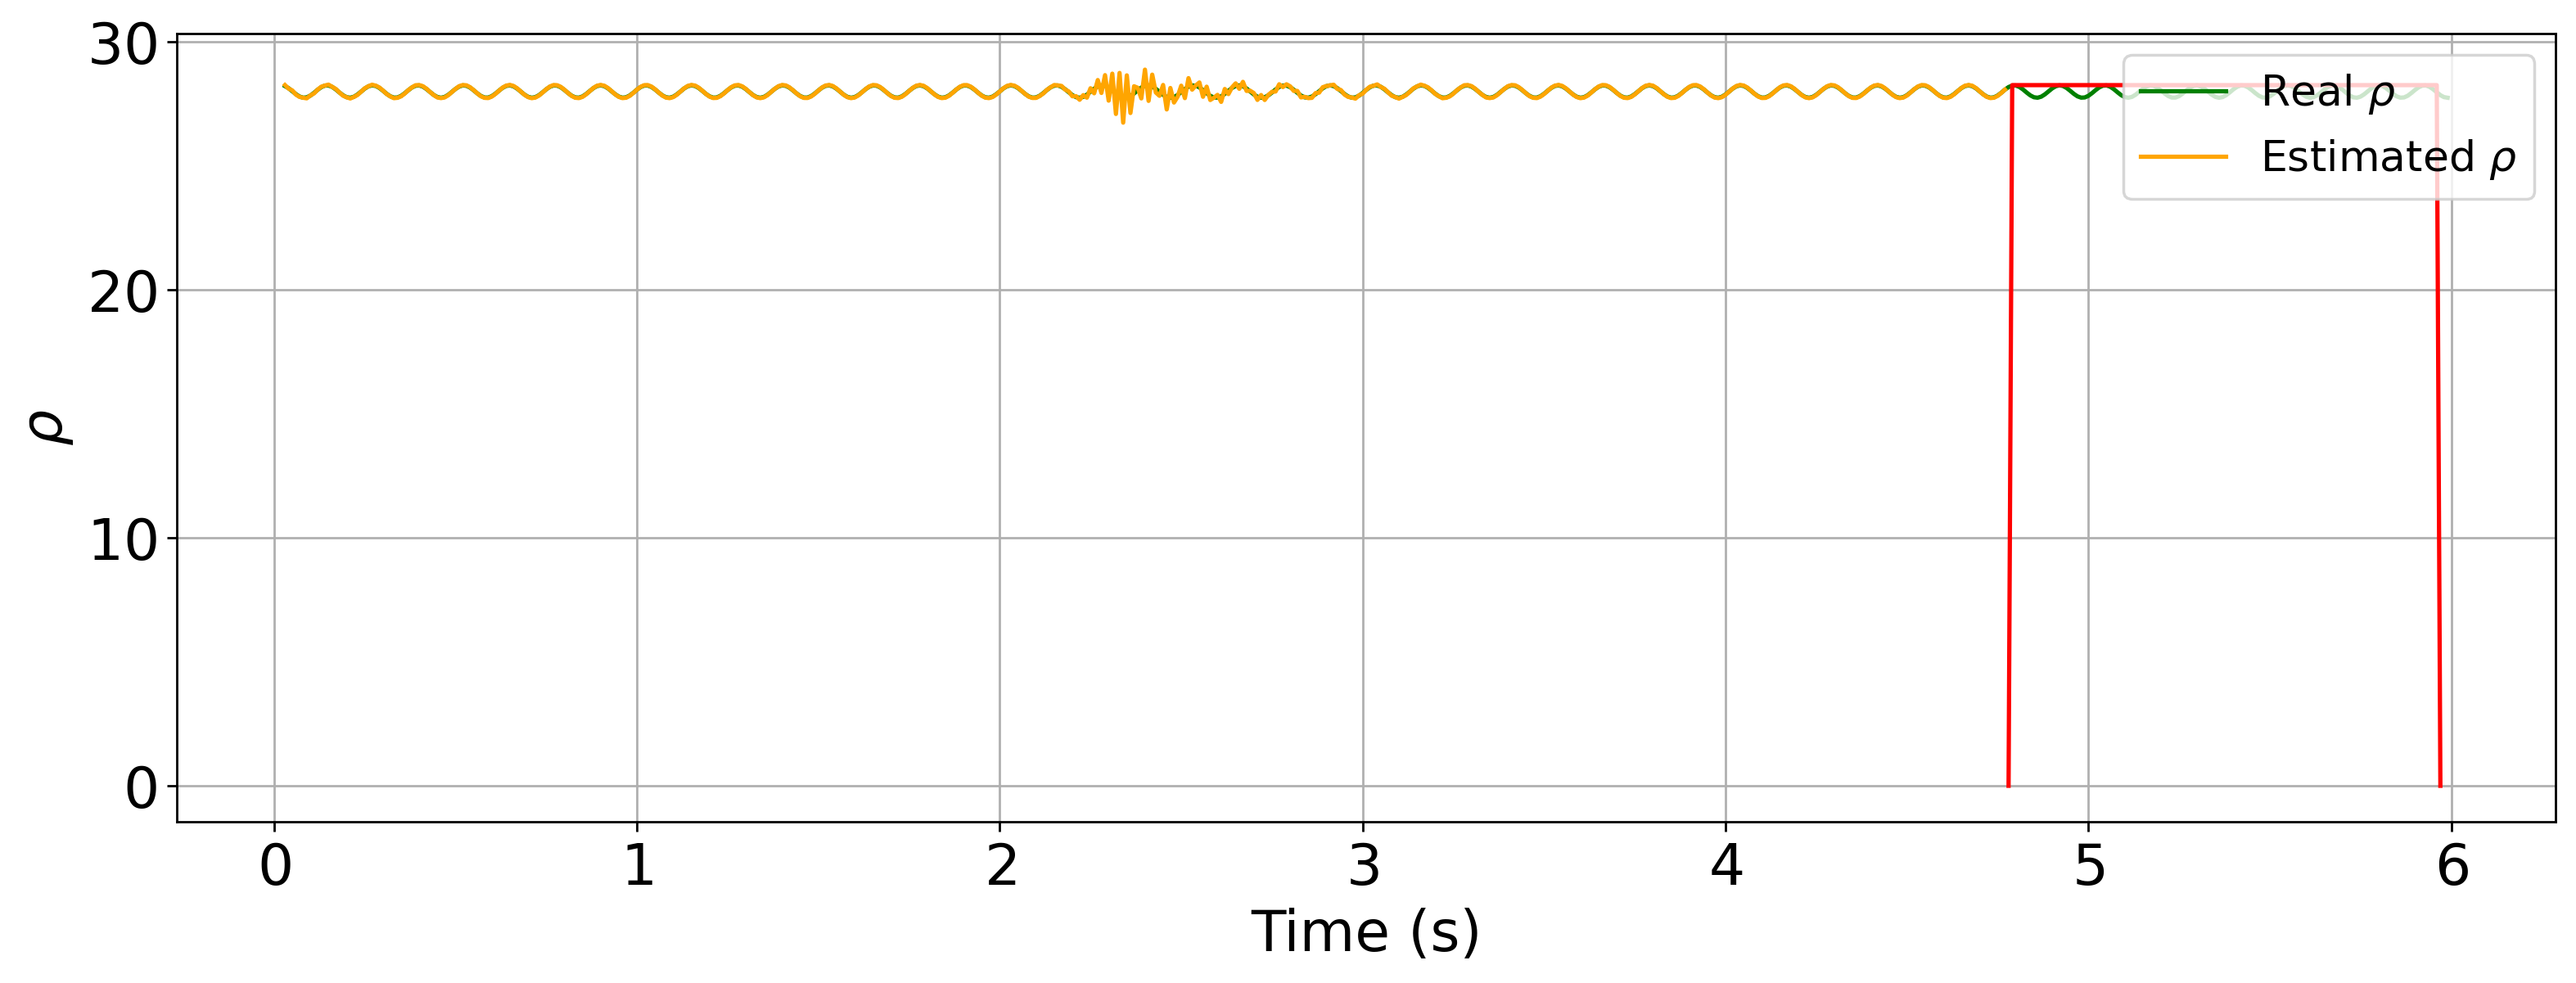

In [624]:
import matplotlib.pyplot as plt



fig=plt.figure(figsize=(15, 5), dpi= 250, facecolor='w', edgecolor='k')
plt.plot(t[3:],NN_output[1,0,1:],'green')
plt.plot(t[3:N_train],pred_train[1,0,1:-2],'orange')
plt.plot(t[N_train:-2],pred_test[1,0,:],'red')
#plt.plot(t[2:N_train],pred_train[2,0,1:],'orange')

plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'${\rho}$', fontsize=20)
plt.tick_params(labelsize=20)
plt.legend([r'Real ${\rho}$',r'Estimated ${\rho}$'],loc='upper right', fontsize=15);
#plt.ylim(bottom= -2*10**5)
#plt.ylim(top=1.5*10**7)
plt.tick_params(axis='both', which='major')
plt.ticklabel_format(style='sci', axis='both', scilimits=(0, 3),useMathText=True)

plt.grid()
plt.show()

# NN_output[:,0,i] = np.array([sigma,rho, beta])

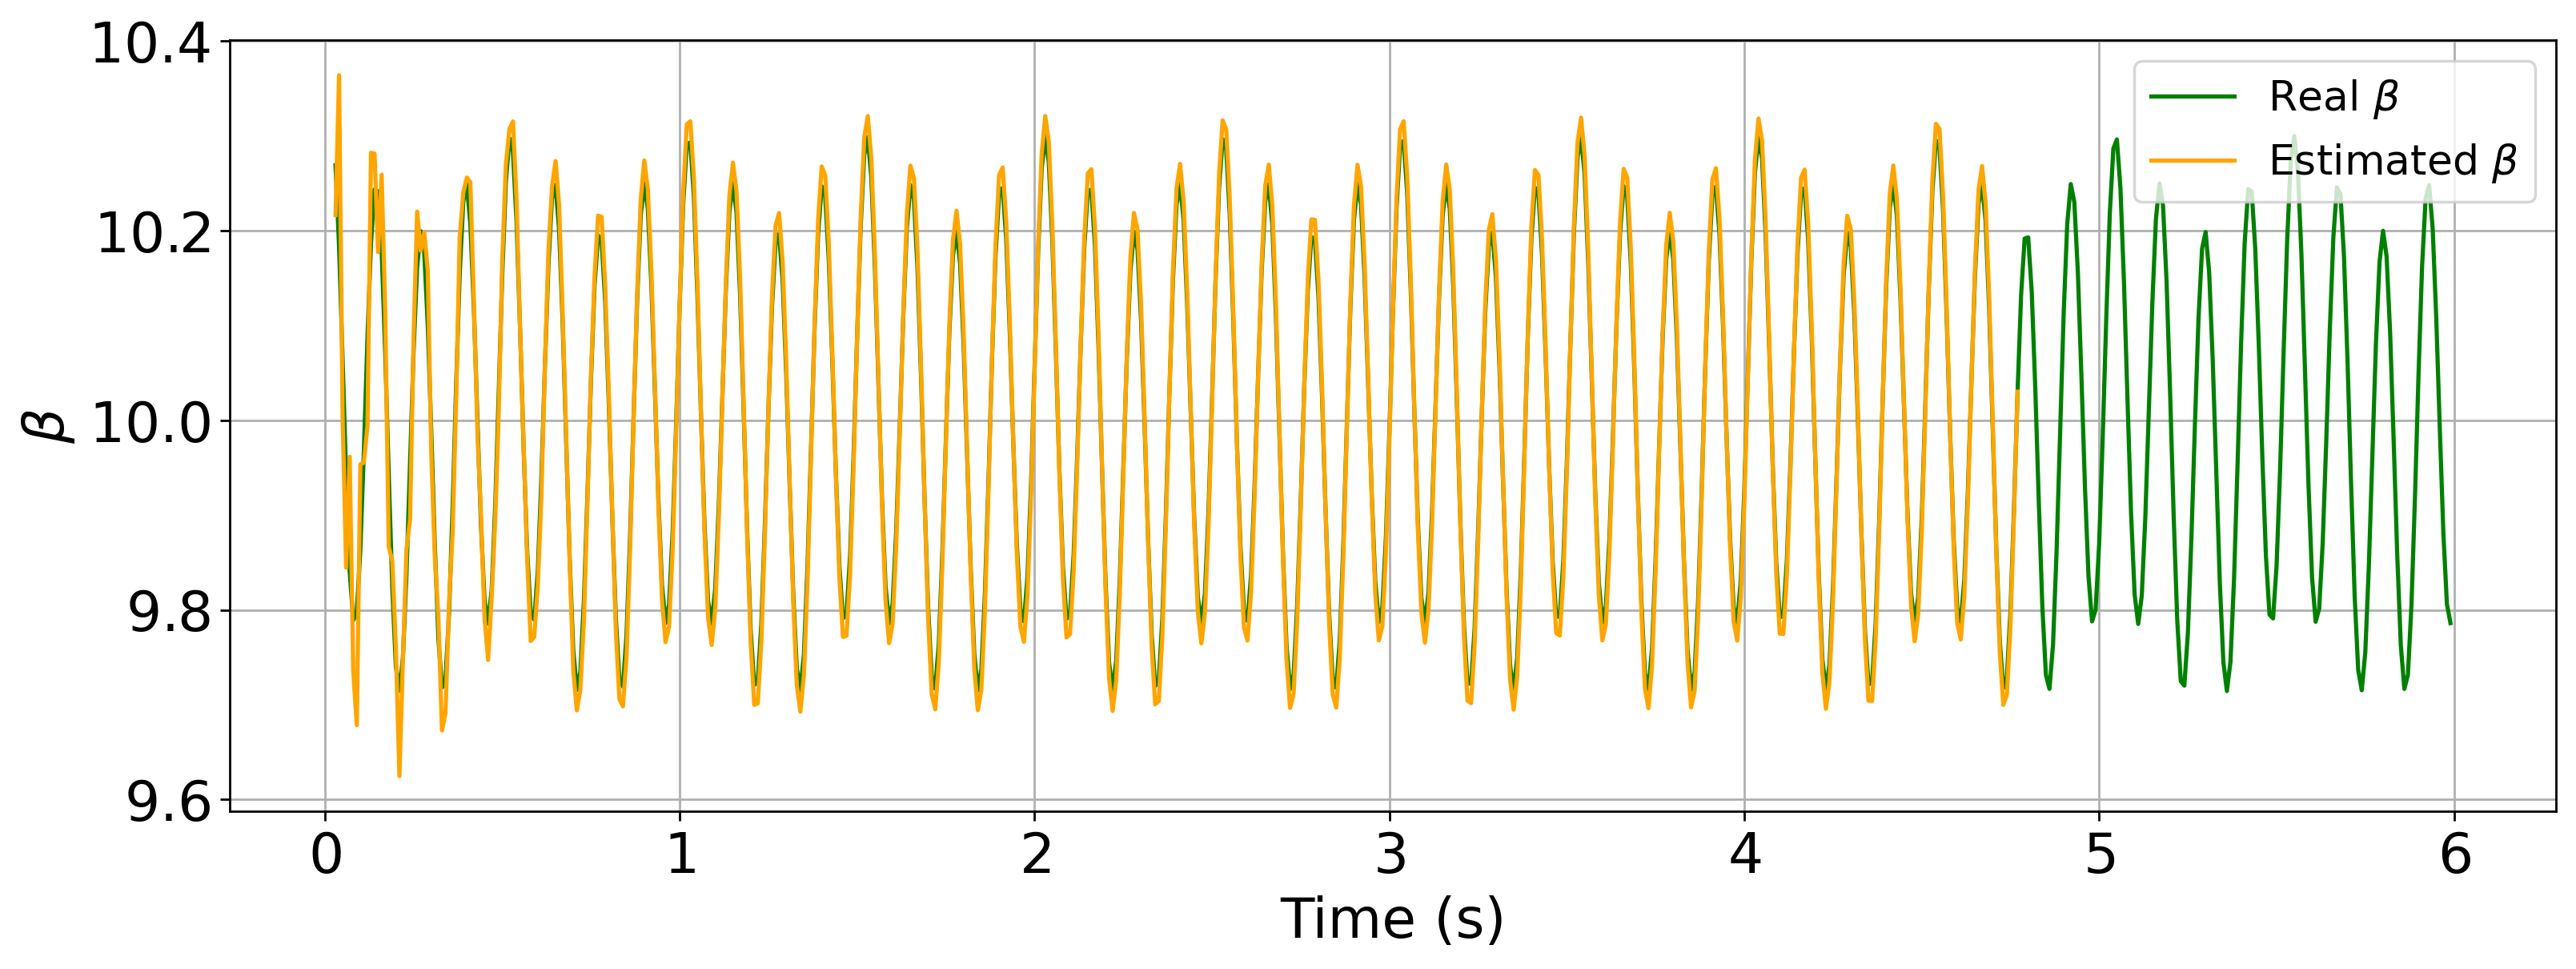

In [622]:
import matplotlib.pyplot as plt



fig=plt.figure(figsize=(15, 5), dpi= 250, facecolor='w', edgecolor='k')
plt.plot(t[3:],NN_output[0,0,1:],'green')
plt.plot(t[3:N_train],pred_train[0,0,1:-2],'orange')
#plt.plot(t[N_train:-2],pred_test[0,0,:],'red')
#plt.plot(t[2:N_train],pred_train[2,0,1:],'orange')

plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'${\beta}$', fontsize=20)
plt.tick_params(labelsize=20)
plt.legend([r'Real ${\beta}$',r'Estimated ${\beta}$'],loc='upper right', fontsize=15);
#plt.ylim(bottom= -2*10**5)
#plt.ylim(top=1.5*10**7)
plt.tick_params(axis='both', which='major')
plt.ticklabel_format(style='sci', axis='both', scilimits=(0, 3),useMathText=True)

plt.grid()
plt.show()

# NN_output[:,0,i] = np.array([sigma,rho, beta])

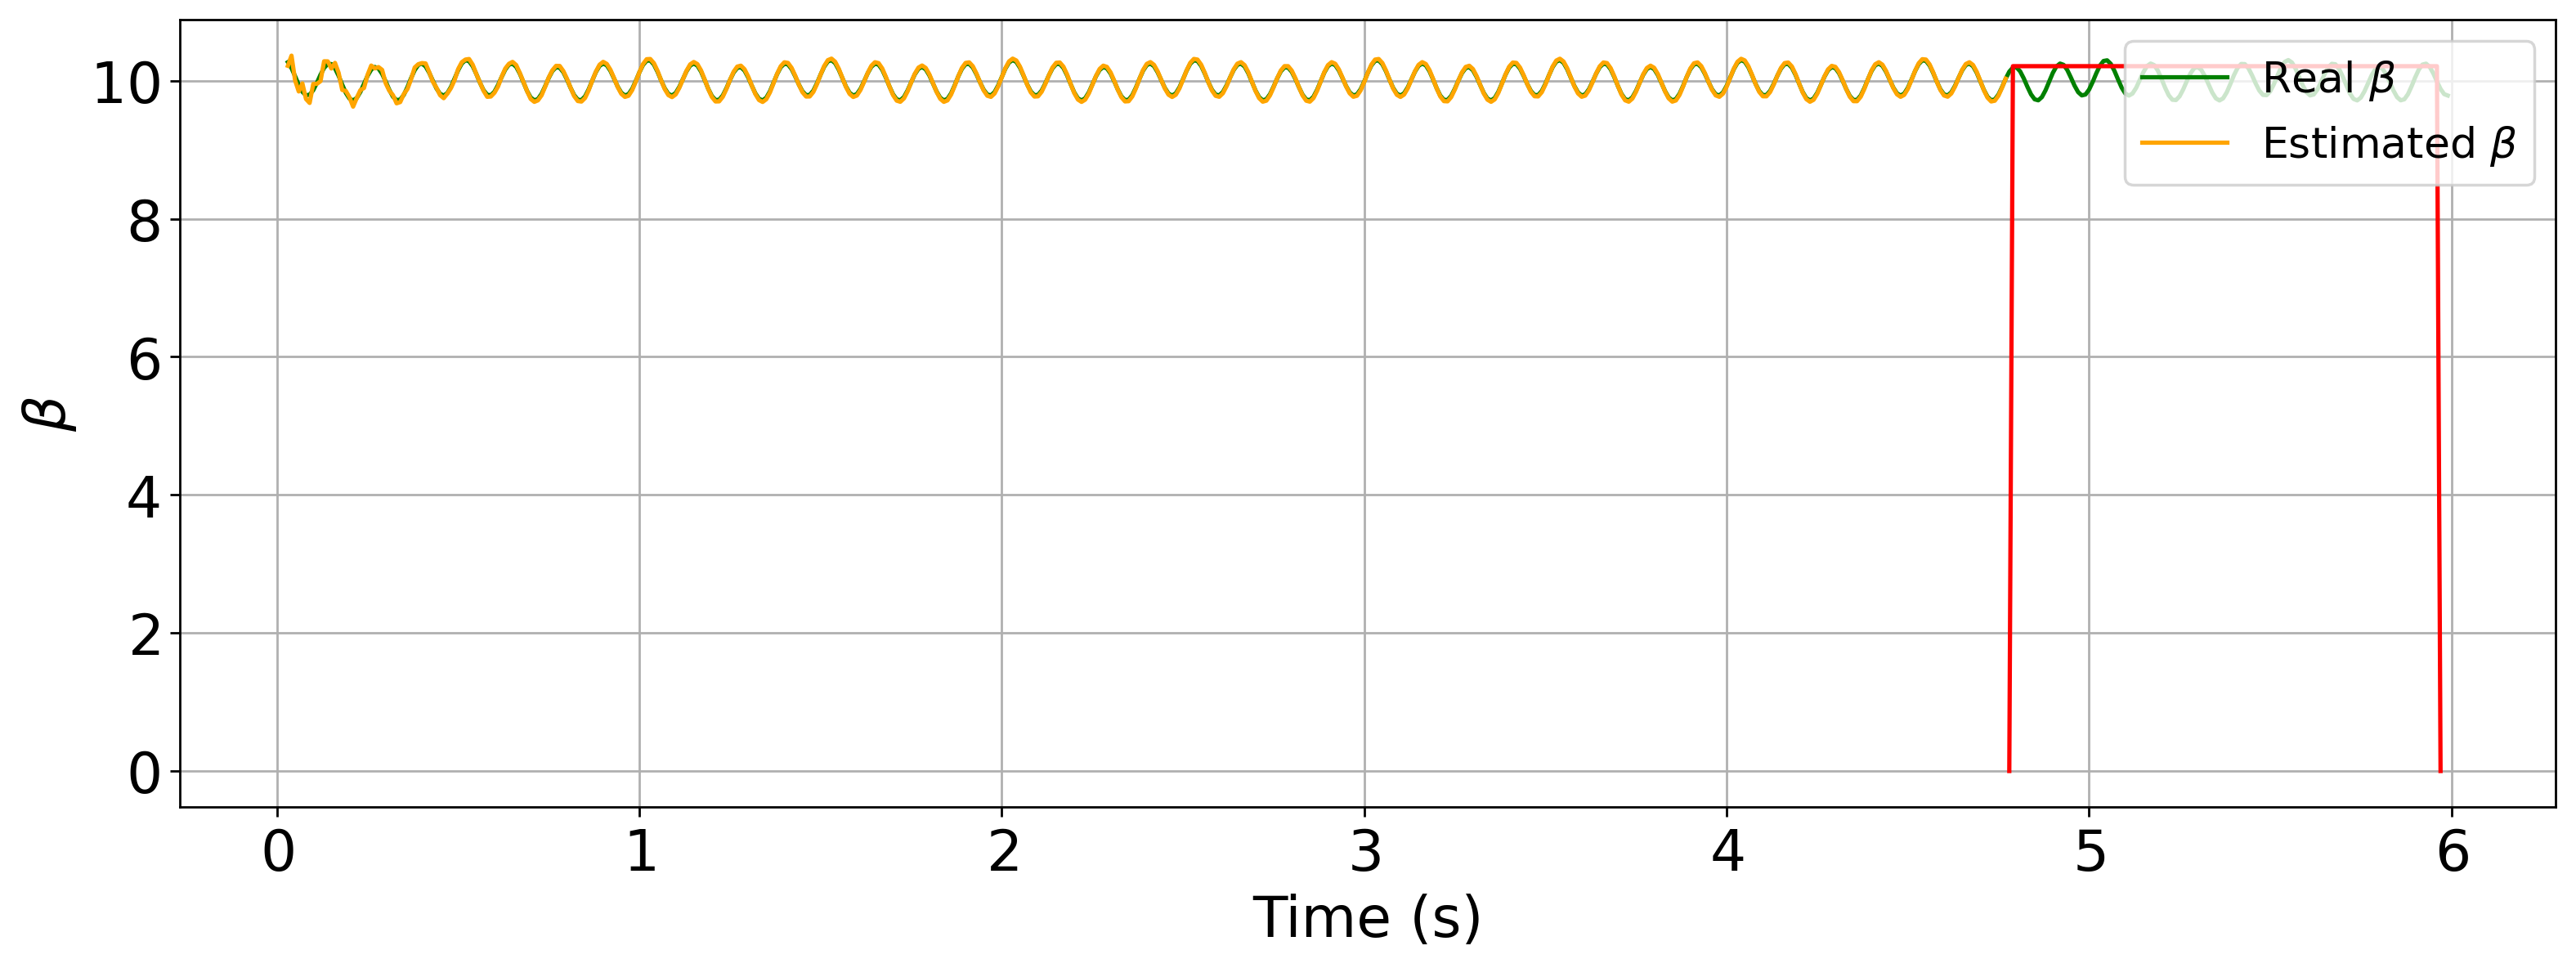

In [623]:
import matplotlib.pyplot as plt



fig=plt.figure(figsize=(15, 5), dpi= 250, facecolor='w', edgecolor='k')
plt.plot(t[3:],NN_output[0,0,1:],'green')
plt.plot(t[3:N_train],pred_train[0,0,1:-2],'orange')
plt.plot(t[N_train:-2],pred_test[0,0,:],'red')
#plt.plot(t[2:N_train],pred_train[2,0,1:],'orange')

plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'${\beta}$', fontsize=20)
plt.tick_params(labelsize=20)
plt.legend([r'Real ${\beta}$',r'Estimated ${\beta}$'],loc='upper right', fontsize=15);
#plt.ylim(bottom= -2*10**5)
#plt.ylim(top=1.5*10**7)
plt.tick_params(axis='both', which='major')
plt.ticklabel_format(style='sci', axis='both', scilimits=(0, 3),useMathText=True)

plt.grid()
plt.show()

# NN_output[:,0,i] = np.array([sigma,rho, beta])